### Analyze daily nba fantasy data from fanduel

1. Compare fantasy points by positions (pg,sg,sf,pf,c's) to see if one group is better than other?
2. Which position performs well for high,mid,low-end salary?
3. How does playing away change scoring or other stats for a player?
4. What is the best possible lineup, total points, pts/$1000's, and cost of lineup for each day?
5. What does playing optimally everyday show?  Any strategies, trends, etc that we can learn?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from salary_optimizer import SalaryOptimizer
%matplotlib inline
# load daily fantasy data
df = pd.read_csv('./fanduel_salaries_w_stats.csv')
df.head()

,Unnamed: 0,position,name,fd_points,salary,team,opp,score,min,game_date,points,rebounds,asst,steal,blks,to,3s,fg,ft
0,0,SG,"McCollum, C.J.^",58.5,"$7,500",por,@ min,95-89,39:14,1-1-2017,43,5,3,3,1,3,3,16-25,8-9
1,1,PG,"Lowry, Kyle^",58.3,"$9,100",tor,@ lal,123-114,39:02,1-1-2017,41,9,7,0,0,4,6,12-16,11-11
2,2,PG,"Russell, D'Angelo^",42.3,"$5,900",lal,v tor,114-123,30:58,1-1-2017,28,4,5,1,0,0,6,9-18,4-6
3,3,SG,"DeRozan, DeMar^",39.7,"$8,800",tor,@ lal,123-114,35:18,1-1-2017,31,1,3,1,1,1,0,10-25,11-13
4,4,SG,"Caldwell-Pope, Kentavious^",39.7,"$5,400",det,@ mia,107-98,39:36,1-1-2017,23,6,5,2,0,2,4,9-15,1-2


In [21]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#### Utility routines to cleanup data

In [3]:
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [4]:
def home_away(opp_str):
    '''
    INPUT
        op_str - a string of one of the values from the opponent column
    
    OUTPUT
        return 1 if the string contains "@" - indicates away
        return 0 otherwise - home
    
    '''
    if "@" in opp_str:
        return 1
    return 0

In [5]:
def get_ready_for_analysis(df):
    #drop first column.not needed
    df = df.drop(df.columns[0], axis=1)
    # drop players without any scores
    df = df[df.fd_points != 0]
    # convert salary to float
    df['salary'] = df['salary'].apply(clean_currency).astype('float')
    # convert minutes to int.  just drop seconds.  It is not big deal for this analysis
    df['min'] = df['min'].str.split(":").str.get(0)
    # replace DNP
    df['min'] = df['min'].str.replace('DNP', '0').astype(int)
    # create a new column indicating home or away games. 0 - home 1-away
    df["home_away"] = df["opp"].apply(home_away)
    
    return df

In [6]:
df = get_ready_for_analysis(df)
df.head()

,position,name,fd_points,salary,team,opp,score,min,game_date,points,rebounds,asst,steal,blks,to,3s,fg,ft,home_away
0,SG,"McCollum, C.J.^",58.5,7500.0,por,@ min,95-89,39,1-1-2017,43,5,3,3,1,3,3,16-25,8-9,1
1,PG,"Lowry, Kyle^",58.3,9100.0,tor,@ lal,123-114,39,1-1-2017,41,9,7,0,0,4,6,12-16,11-11,1
2,PG,"Russell, D'Angelo^",42.3,5900.0,lal,v tor,114-123,30,1-1-2017,28,4,5,1,0,0,6,9-18,4-6,0
3,SG,"DeRozan, DeMar^",39.7,8800.0,tor,@ lal,123-114,35,1-1-2017,31,1,3,1,1,1,0,10-25,11-13,1
4,SG,"Caldwell-Pope, Kentavious^",39.7,5400.0,det,@ mia,107-98,39,1-1-2017,23,6,5,2,0,2,4,9-15,1-2,1


#### Compare fantasy points by positions (pg,sg,sf,pf,c's) to see if one group is better than other?
* Plot position vs fantasy points to see the data distribution

In [7]:
# how may rows, columns
df.shape

(17082, 19)

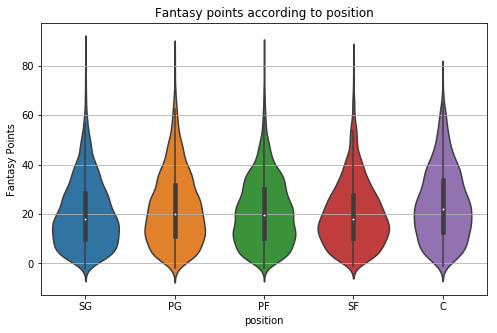

In [50]:
# use violin plots to display distribution
fig,axes = plt.subplots(figsize=(8,5))
sns.violinplot('position','fd_points',data=df,ax=axes,title='ldjfldfj')
axes.yaxis.grid(True)
axes.set_ylabel('Fantasy Points')
axes.set_title('Fantasy points according to position')
plt.show()

#### observations:
1. Scoring among positions looks similar.  
2. Each of the positions has more players scoring between 0-20 fantasy points.  Chart also indicates that there are slightly more SG and SF's in the range of 0-20 compare to centers (C).
3. Pool of players reduces as the fantasy points increse.  This makes sense as not everyone can score in the high digits.  There are tiers of players.  Only few superstars in the league.  However, there are slightly more PG's and C's that score over 60.
4. SG has scored the most fantasy points followed by PG,PF,SF,C

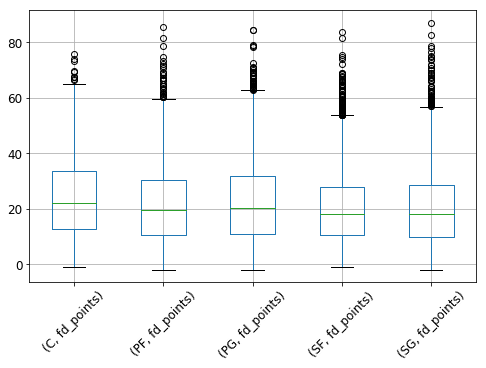

In [51]:
# another way to look at the data
df[['position','fd_points']].groupby('position').boxplot(subplots=False, rot=45,fontsize=12,figsize=(8,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f2a2a20>,
      dtype=object)

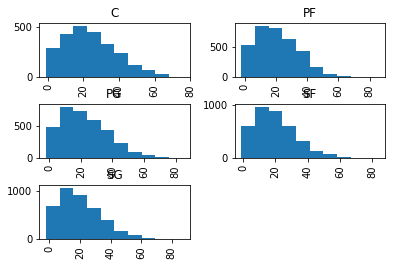

In [10]:
# yet another way to plot distribution
df['fd_points'].hist(by=df['position'])

#### Which position performs well for high,mid,low-end salary?

In [11]:
# the violin plot indicates that there are tiers of players.  Lets divide the positions by range of salaries
sal_bins = pd.cut(df['salary'],[0,3500,5500,7500,9500,14000])

In [12]:
df['salary'].describe()

count    17082.000000
mean      5004.109589
std       1850.763912
min       3500.000000
25%       3500.000000
50%       4200.000000
75%       5900.000000
max      13100.000000
Name: salary, dtype: float64

In [13]:
# Average points scored by each position for given salary range
df.groupby([sal_bins,'position'])['fd_points'].agg(['mean'])

mean
salary        position           
(0, 3500]     C         11.704612
              PF        10.507877
              PG        10.709360
              SF        10.693788
              SG        10.393849
(3500, 5500]  C         19.473647
              PF        19.172353
              PG        18.801044
              SF        19.003852
              SG        18.480242
(5500, 7500]  C         30.803356
              PF        29.153056
              PG        30.172364
              SF        29.128901
              SG        30.060720
(7500, 9500]  C         39.764217
              PF        37.214552
              PG        40.485450
              SF        39.367480
              SG        39.795298
(9500, 14000] C         46.975573
              PF        52.698361
              PG        48.285606
              SF        48.998601
              SG        50.148810

In [14]:
# look it in table format
df.groupby([sal_bins,'position'])['fd_points'].agg(['mean']).unstack()

mean                                            
position               C         PF         PG         SF         SG
salary                                                              
(0, 3500]      11.704612  10.507877  10.709360  10.693788  10.393849
(3500, 5500]   19.473647  19.172353  18.801044  19.003852  18.480242
(5500, 7500]   30.803356  29.153056  30.172364  29.128901  30.060720
(7500, 9500]   39.764217  37.214552  40.485450  39.367480  39.795298
(9500, 14000]  46.975573  52.698361  48.285606  48.998601  50.148810

[]

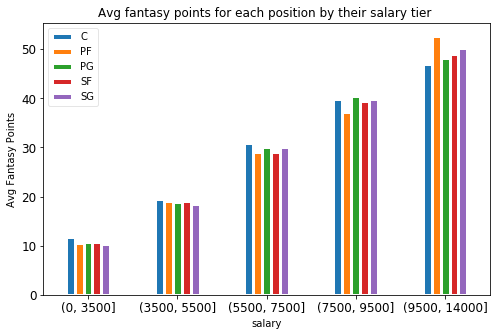

In [49]:
# compare average fantasy points for each position in a given salary range
ax = df.groupby([sal_bins,'position'])['fd_points'].agg(['mean']).unstack().plot(kind='bar',fontsize=12,
                                                                                 edgecolor='white',linewidth=3,
                                                                                 title='Avg fantasy points for each position by their salary tier ',
                                                                                 rot=0,figsize=(8,5),legend=False)
patches,labels = ax.get_legend_handles_labels()
labels = ['C','PF','PG','SF','SG']
ax.set_ylabel('Avg Fantasy Points')
ax.legend(patches,labels,loc='best',fancybox=True,framealpha=0.5)
ax.plot()

#### Observations:
1. No suprise.  As salary increases so does avg fantsy points.
2. Center position on avg scores more points in the lower range slary (0-7500).
3. PF's on average score higher compared to other position for higher salary range (\$9500-1400)

#### Does playing away matter
1. Create different datasets for home and away
2. Compare two different groups using avgs or percentages
3. Create chart showing the diffs

In [16]:
def home_away_stats(df):
    # get average for specific columns and return as dataframe
    columns = ['fd_points','salary','min','points','rebounds','asst','steal','blks','to','3s']
    df = pd.DataFrame(df[columns].mean(),columns=['avg'])
    return df

In [17]:
# separate out home and away data
home_df_stats = home_away_stats(df[df['home_away'] == 0])
away_df_stats = home_away_stats(df[df['home_away'] == 1])
comp_df = pd.merge(away_df_stats,home_df_stats, left_index=True, right_index=True)
comp_df.columns = ['away', 'home']
# get percentage change
comp_df['Percentage_Change'] = (comp_df['home'] - comp_df['away']) / comp_df['home']
comp_df.style.bar(subset=['Percentage_Change'], align='mid', color=['#d65f5f', '#5fba7d'])

,away,home,Percentage_Change
fd_points,21.1179,21.7348,0.0283831
salary,4999.5,5008.72,0.00184143
min,22.9767,22.9745,-9.60812e-05
points,10.5773,10.799,0.0205332
rebounds,4.25791,4.39185,0.0304992
asst,2.27981,2.38553,0.0443196
steal,0.74877,0.743797,-0.00668649
blks,0.462169,0.498478,0.0728403
to,1.31846,1.32233,0.00292877
3s,1.07988,1.10662,0.0241693


#### Observations:
1. players block 7% more shots at home
2. Players turn the ball over 4% more on the road
3. Fantasy points decrease by 2% on the road.
4. Rebounds are lower by 3% on the road

#### Let's see if we can figure out a strategy from optimal lineups
1. For each day, figure out the optimal lineup. 
2. Create a dataframe containing optimal lineup, salary, pts/1000's, and fantasy points
3. Plot the distribution of data by each group.
4. For optimal lineups, figure out the count of each position within a slary range.  Which salary range has the highest count?  

In [18]:
def get_optimal_lineups(df):
    '''
    df - dataframe containing player position,name,points,salary, etc
    
    For each day figure out the optimal lineup.
    
    return a dataframe containing the optimal lineup along with pts/1000's dollar 
    '''
    columns = ['position','name','fd_points','salary']
    # according to the rules of the game from fanduel, we are required to pick 2 PG's,2 SG's,..., and 1 center 
    req_pos = {
        "PG": 2,
        "SG": 2,
        "SF": 2,
        "PF": 2,
        "C": 1
    }
    # salary cap.  maximize scores without exceeding salary cap
    SALARY_CAP = 60000
    opt_all_df = pd.DataFrame()
    for day in df.game_date.unique():
        df_day = df[df.game_date == day]
        df_day = df_day[columns]
        df_day = df_day.rename(columns={"fd_points":"points"})
        so = SalaryOptimizer(req_pos,SALARY_CAP)
        lineupDF = so.optimize(df_day)
        lineupDF['game_date'] = [day]*lineupDF.shape[0]
        opt_all_df = pd.concat([opt_all_df, lineupDF])
    return opt_all_df

In [19]:
optimal_score_df = get_optimal_lineups(df)

In [20]:
optimal_score_df.head()

,position,name,points,salary,pts/$ooo,game_date
0,C,"Drummond,Andre^",51.6,7400.0,6.972973,1-1-2017
1,PF,"Aldridge,LaMarcus^",49.6,7000.0,7.085714,1-1-2017
2,PF,"Millsap,Paul^",52.1,7500.0,6.946667,1-1-2017
3,PG,"Lowry,Kyle^",58.3,9100.0,6.406593,1-1-2017
4,PG,"Russell,D'Angelo^",42.3,5900.0,7.169492,1-1-2017


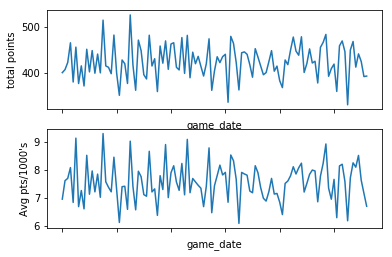

In [39]:
# plot total points and avg points per $1000 dollar for each lineup.  Cost/$1000 dollar gives us the value for every
# $1000 dollar spent on salary
fix, axes = plt.subplots(nrows=2)
axes[0].set_ylabel('total points')
axes[1].set_ylabel("Avg pts/1000's")
optimal_score_df.groupby('game_date')['points'].sum().plot(ax=axes[0])
optimal_score_df.groupby('game_date')['pts/$ooo'].mean().plot(ax=axes[1])

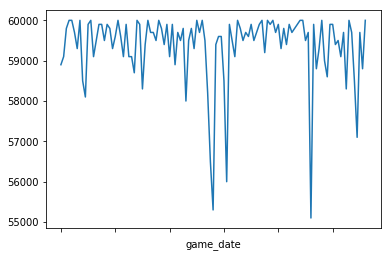

In [437]:
optimal_score_df.groupby('game_date')['salary'].sum().plot()

In [440]:
# get the count of each position in a given salary range
df.groupby([sal_bins,'position'])['position'].count()

salary         position
(0, 3500]      C            477
               PF           876
               PG           812
               SF           982
               SG          1138
(3500, 5500]   C           1127
               PF          1530
               PG          1532
               SF          1843
               SG          1817
(5500, 7500]   C            447
               PF           720
               PG           626
               SF           564
               SG           639
(7500, 9500]   C            313
               PF           268
               PG           378
               SF           123
               SG           319
(9500, 14000]  C            131
               PF            61
               PG           132
               SF           143
               SG            84
Name: position, dtype: int64

Text(0, 0.5, 'Count')

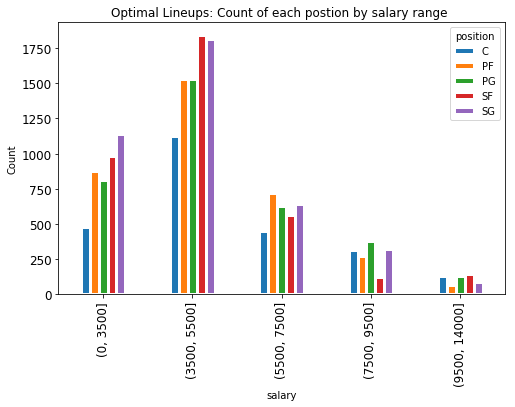

In [48]:
ax = df.groupby([sal_bins,'position'])['position'].count().unstack().plot(kind='bar',figsize=(8,5),fontsize=12,
                                                                                 edgecolor='white',linewidth=3,
                                                                                 title='Optimal Lineups: Count of each postion by salary range ')
ax.set_ylabel('Count')

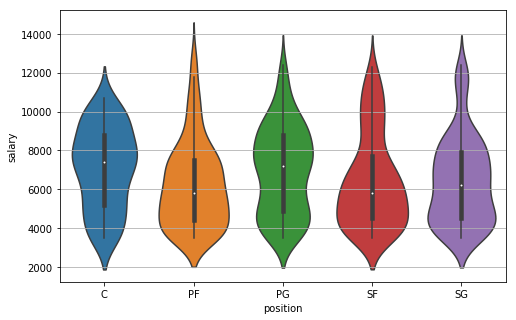

In [45]:
# What does the distribution look like for optimal lineup and position salary
fig,axes = plt.subplots(figsize=(8,5))
sns.violinplot('position','salary',data=optimal_score_df,ax=axes)
axes.yaxis.grid(True)
plt.show()

##### Observations: 
1. Optimal lineups consistemtly generate total points between 400-500.  There are few outliers above \$500 and below \$400.  May be good to target totals between this range while building your own lineups
2. Average cost per \$1000 spent is consistently between 7-8.  Good value.  
3. Most optimal lineups include positions with salary range of $3500-$5000. 
4. Good to pickup SG and SF with salary range of $3500-$5000 compared to centers.  So, if you have a choice between C and SG/SF, pick SG/SF.
5. If you have to pick a player in the range of \$5000-7500, it is better to pick a PF.
6. Violin plot indicates to pick PG and C between \$8000-10000 over other positions with a lean towards centers.
7. Positions with higher salary greater than \$9500 are only included in the optimal lineups 12% of the time.  
8. Overall, don't go with big names (high salary) and focus on players in the range of $3500-5000 but if you feel like spending higher dollars, it is best to spend it on PG's and C's.  
9. Optimal lineups here hopefully provide one additionally data point and help while generating your lineups.  
10. Hardest part is to predict/find players beforehand with low salaries with potential of scoring big.  